# Jegadeesh-Titman rolling portfolios

- Relative strength, momentum effect
- Overlapping portfolio returns, Newey-West correction, rolling portfolios

Copyright 2023, Terence Lim

MIT License

In [4]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from tqdm import tqdm
from finds.database import SQL, Redis
from finds.busday import BusDay
from finds.structured import CRSP, Finder
from finds.recipes import fractiles
from finds.display import show, plot_date
from conf import credentials, VERBOSE, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
imgdir = paths['images']

begyear = 1927
endyear = 2022
retdates = bd.date_range(bd.begyr(begyear), bd.endyr(endyear), 'begmo')
rebaldates = bd.offset(retdates, -1)
percentiles = [20, 80]   # quintile spread percentile breakpoints
maxhold = 6    # hold each monthly-rebalanced portfolio for 6 months

## Overlapping returns: hold monthly spread portfolios for 6 months

In [5]:
mom = []
for rebaldate in tqdm(rebaldates):
    
    # determine required dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal

    # retrieve universe, required available prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         crsp.get_ret(start, end).rename('mom'),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
    df = pd.concat(p, axis=1, join='inner').dropna()

    # quintile spread breakpoints determined from NYSE subset
    tritile = fractiles(values=df['mom'],
                        pct=percentiles,
                        keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # compute and store cap-weighted average returns over maxhold periods
    begret = bd.offset(rebaldate, 1)
    nhold = min(maxhold, len(retdates) - retdates.index(begret))
    endret = bd.endmo(begret, nhold - 1)  # if maxhold is beyond end date
    rets = crsp.get_ret(begret, endret, delist=True)
    ret = rets.reindex(port.index).fillna(0.).mul(port, axis=0).sum()

    mom.append(float(ret) / nhold)

DataFrame({'mean': np.mean(mom), 'std': np.std(mom)},
          index=['Overlapping Returns'])

100%|███████████████████████████████████████| 1152/1152 [24:01<00:00,  1.25s/it]


,mean,std
Overlapping Returns,0.004584,0.024666


## Non-overlapping: monthly average returns of past 6 months' rebalances

In [6]:
# Jegadeesh-Titman rolling portfolios
ports = []  # to roll 6 past portfolios
jt = []
for rebaldate in tqdm(rebaldates):
    
    # determine required dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal
    
    # retrieve universe, required available prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         crsp.get_ret(start, end).rename('mom'),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
    df = pd.concat(p, axis=1, join='inner').dropna()
    
    # quintile spread breakpoints determined from NYSE subset
    tritile = fractiles(values=df['mom'],
                        pct=percentiles,
                        keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # keep up to 6 months of monthly-rebalanced portfolios
    ports.insert(0, port)
    if len(ports) > maxhold:
        ports.pop(-1)

    # compute all 6 portfolios' monthly capwtd returns, and store eqlwtd average
    begret = bd.offset(rebaldate, 1)
    endret = bd.endmo(begret)
    rets = crsp.get_ret(begret, endret, delist=True)
    ret = np.mean([rets.reindex(p.index).fillna(0.).mul(p, axis=0).sum()
                   for p in ports])
    jt.append(ret)

    # adjust stock weights by monthly capital appreciation
    retx = crsp.get_ret(begret, endret, field='retx')
    ports = [(1+retx.reindex(p.index).fillna(0.)).mul(p, axis=0) for p in ports]

DataFrame({'mean': np.mean(jt), 'std': np.std(jt)},
          index=['Non-overlapping Returns'])

100%|███████████████████████████████████████| 1152/1152 [25:06<00:00,  1.31s/it]


,mean,std
Non-overlapping Returns,0.004515,0.051258


## Autocorrelations of portfolio returns

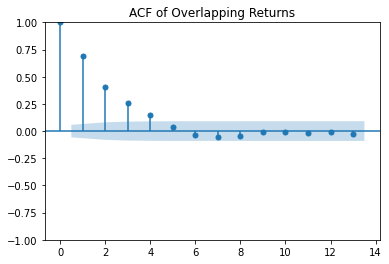

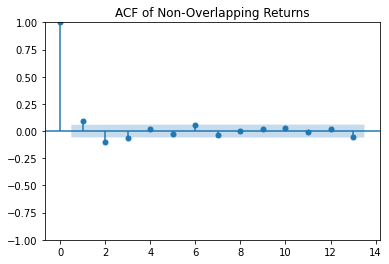

In [7]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(mom,
                         lags=13,
                         title='ACF of Overlapping Returns')
plt.savefig(imgdir / 'overlap.jpg')
sm.graphics.tsa.plot_acf(jt,
                         lags=13,
                         title='ACF of Non-Overlapping Returns')
plt.savefig(imgdir / 'nonoverlap.jpg')

## Newey-West corrected t-stats

In [8]:
res = []
keys = ['All stocks overlapping', 'All stocks non-overlapping']
for out, label in zip([mom, jt], keys):
    data = DataFrame(out, columns=['ret'])
    reg = smf.ols('ret ~ 1',data=data).fit()
    a = Series({stat: round(float(getattr(reg, stat)), 6)
                for stat in ['params','bse','tvalues','pvalues']},
               name='uncorrected')  # coef, stderr, t-value, P>|z|
    #print(reg.summary())

    reg = smf.ols('ret ~ 1',data=data)\
             .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    b = Series({stat: round(float(getattr(reg, stat)), 6)
                for stat in ['params','bse','tvalues','pvalues']},
               name='NeweyWest')   # coef, stderr, t-value, P>|z|
    res.append(pd.concat([a, b], axis=1))
show(pd.concat(res, axis=1, keys=keys),
     caption='Uncorrected and Newey-West corrected standard errors', **SHOW)     

All stocks overlapping  \
                                                              uncorrected   
Uncorrected and Newey-West corrected standard e...                          
params                                                             0.0046   
bse                                                                0.0007   
tvalues                                                            6.3051   
pvalues                                                            0.0000   

                                                              \
                                                   NeweyWest   
Uncorrected and Newey-West corrected standard e...             
params                                                0.0046   
bse                                                   0.0013   
tvalues                                               3.5293   
pvalues                                               0.0004   

                                                   All stocks non-overlapping  \
                                                                  uncorrected   
Uncorrected and Newey-West corrected standard e...                              
params                                                                 0.0045   
bse                                                                    0.0015   
tvalues                                                                2.9884   
pvalues                                                                0.0029   

                                                              
                                                   NeweyWest  
Uncorrected and Newey-West corrected standard e...            
params                                                0.0045  
bse                                                   0.0015  
tvalues                                               3.0591  
pvalues                                               0.0022

## Plot cumulative monthly average returns of Jegadeesh-Titman rolling portfolios

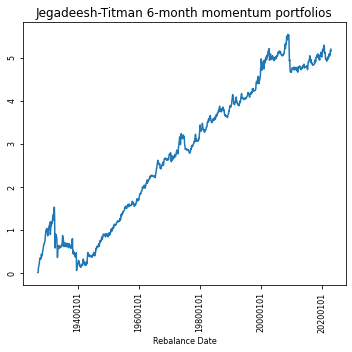

In [9]:
fig, ax = plt.subplots(figsize=(5, 5), clear=True)
plot_date(DataFrame(index=rebaldates, data=np.cumsum(jt), columns=['momentum']),
          ax=ax, fontsize=8, rotation=90,
          ylabel='Cumulative Returns', xlabel='Rebalance Date',
          title='Jegadeesh-Titman 6-month momentum portfolios')
plt.tight_layout()
plt.savefig(imgdir / 'jegadeesh_titman.jpg')

## Plot histogram of monthly portfolio returns   

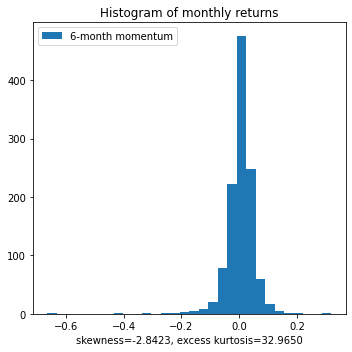

In [10]:
fig, ax = plt.subplots(1, 1, clear=True, figsize=(5, 5))
ax.hist(jt, bins=30)
ax.set_title(f"Histogram of monthly returns")
ax.legend(['6-month momentum'])
kurt = kurtosis(jt, bias=True, fisher=True)  # excess kurtosis
skewness = skew(jt, bias=True)
ax.set_xlabel(f"skewness={skewness:.4f}, excess kurtosis={kurt:.4f}")
plt.tight_layout()
plt.savefig(imgdir / 'jegadeesh_titman_hist.jpg')